# Transfer Learning Using Pretrained Convolutioal Neural Networ (CNN)

In [1]:
import os

#!pip install tensorflow==1.14.0
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  2.4.1


In [2]:
print("TensorFlow version is ", tf.__version__)

TensorFlow version is  2.4.1


In [3]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/\
    mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [4]:
base_dir

'/Users/lalithap/.keras/datasets/cats_and_dogs_filtered'

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


In [6]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1/255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1/255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary',
                shuffle=False) # Might need to add

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
len(model.trainable_variables)

2

In [14]:
model.trainable_variables[0]

<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
array([[-0.03608978],
       [ 0.03818947],
       [ 0.06086178],
       ...,
       [-0.04942052],
       [-0.02987564],
       [ 0.01689374]], dtype=float32)>

In [15]:
# Warning! This takes several minutes to complete.

epochs = 5
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/5
62/62 [==============================] - 32s 477ms/step - loss: 0.5405 - accuracy: 0.7364 - val_loss: 0.4425 - val_accuracy: 0.8347
Epoch 2/5
62/62 [==============================] - 29s 472ms/step - loss: 0.4328 - accuracy: 0.8368 - val_loss: 0.3653 - val_accuracy: 0.8760
Epoch 3/5
62/62 [==============================] - 30s 482ms/step - loss: 0.3715 - accuracy: 0.8818 - val_loss: 0.3088 - val_accuracy: 0.8992
Epoch 4/5
62/62 [==============================] - 30s 489ms/step - loss: 0.3055 - accuracy: 0.9003 - val_loss: 0.2678 - val_accuracy: 0.9284
Epoch 5/5
62/62 [==============================] - 30s 483ms/step - loss: 0.2642 - accuracy: 0.9155 - val_loss: 0.2344 - val_accuracy: 0.9335


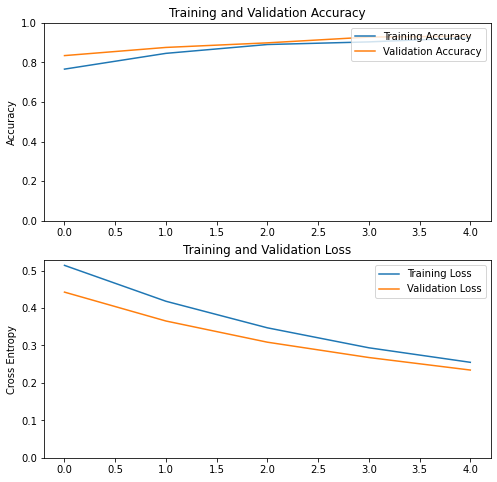

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(plt.ylim()), 1])
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,max(plt.ylim())])
ax[1].set_title('Training and Validation Loss')
plt.show()

In [18]:
base_model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [20]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [21]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [23]:
len(model.trainable_variables)

56

In [24]:
# This will also require some time to run!

history_fine = model.fit(train_generator,
                                   steps_per_epoch=steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/5
62/62 [==============================] - 45s 674ms/step - loss: 0.8047 - accuracy: 0.5487 - val_loss: 0.3860 - val_accuracy: 0.8619
Epoch 2/5
62/62 [==============================] - 43s 700ms/step - loss: 0.6448 - accuracy: 0.6307 - val_loss: 0.4259 - val_accuracy: 0.8377
Epoch 3/5
62/62 [==============================] - 43s 698ms/step - loss: 0.5273 - accuracy: 0.8253 - val_loss: 0.3946 - val_accuracy: 0.8730
Epoch 4/5
62/62 [==============================] - 43s 695ms/step - loss: 0.4099 - accuracy: 0.9647 - val_loss: 0.3795 - val_accuracy: 0.8821
Epoch 5/5
62/62 [==============================] - 42s 670ms/step - loss: 0.2839 - accuracy: 0.9939 - val_loss: 0.3423 - val_accuracy: 0.8851


In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

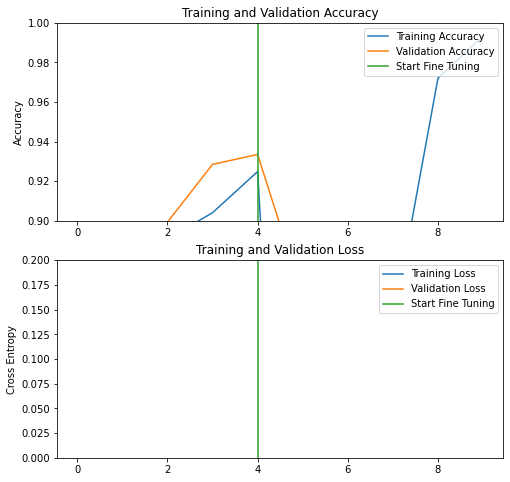

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].set_ylim([0.9, 1])
ax[0].set_ylabel('Accuracy')
ax[0].plot([epochs-1, epochs-1], plt.ylim(), label='Start Fine Tuning')
ax[0].legend(loc='upper right')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_ylim([0, 0.2])
ax[1].set_ylabel('Cross Entropy')
ax[1].plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
ax[1].legend(loc='upper right')
ax[1].set_title('Training and Validation Loss')
plt.show()

In [27]:
# This will also require some time to run!
epochs = 50

history_fine = model.fit(train_generator,
                                   steps_per_epoch=steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/50
62/62 [==============================] - 40s 639ms/step - loss: 0.1768 - accuracy: 1.0000 - val_loss: 0.3583 - val_accuracy: 0.8478
Epoch 2/50
62/62 [==============================] - 40s 652ms/step - loss: 0.1059 - accuracy: 1.0000 - val_loss: 0.4058 - val_accuracy: 0.8065
Epoch 3/50
62/62 [==============================] - 43s 685ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.5449 - val_accuracy: 0.7429
Epoch 4/50
62/62 [==============================] - 42s 676ms/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.6785 - val_accuracy: 0.7177
Epoch 5/50
62/62 [==============================] - 45s 730ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.7915 - val_accuracy: 0.6905
Epoch 6/50
62/62 [==============================] - 43s 692ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.8679 - val_accuracy: 0.6915
Epoch 7/50
62/62 [==============================] - 42s 674ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.5527 - val_accuracy: 0.7974

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

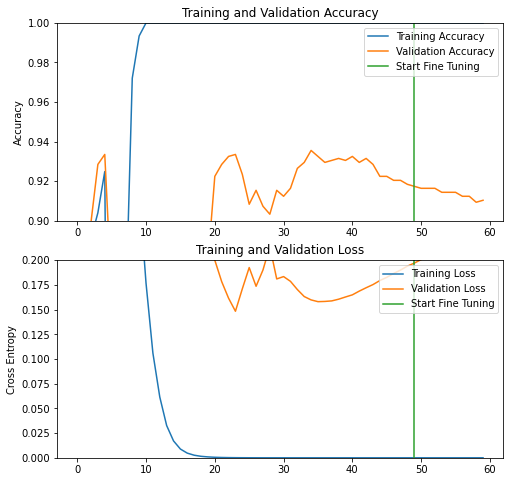

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].set_ylim([0.9, 1])
ax[0].set_ylabel('Accuracy')
ax[0].plot([epochs-1, epochs-1], plt.ylim(), label='Start Fine Tuning')
ax[0].legend(loc='upper right')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_ylim([0, 0.2])
ax[1].set_ylabel('Cross Entropy')
ax[1].plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
ax[1].legend(loc='upper right')
ax[1].set_title('Training and Validation Loss')
plt.show()